In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d

In [2]:
mu0 = np.array([1, 1])
mu1 = np.array([5, 5])
Sigma0 = np.array([[1, 0], [0, 1]])
Sigma1 = np.array([[1, 0], [0, 1]])

X0 = np.random.multivariate_normal(mu0, Sigma0, size=(10000))
X1 = np.random.multivariate_normal(mu1, Sigma1, size=(10000))

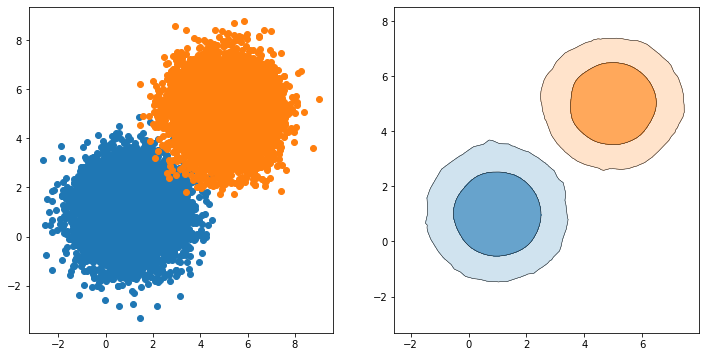

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(X0[:, 0], X0[:, 1])
axs[0].scatter(X1[:, 0], X1[:, 1])

kde_contour_plot_2d(axs[1], X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs[1], X1[:, 0], X1[:, 1])

plt.show()

## 1D Gaussian tension coordinate t

Neural network approach: let t = T(\theta; \alpha)

In [4]:
def get_limits(points):
    min_max = torch.tensor([])
    for row in torch.transpose(points, 0, 1):
        min_val = torch.min(row)  
        max_val = torch.max(row)
        padding = (max_val - min_val) / 100
        min_max = torch.cat((min_max, torch.tensor([[min_val - padding, max_val + padding]])))
    
    return min_max

def uniform_prior_samples(limits, size=10000):
    prior_samples = []
    for limit in limits:
        low_lim = limit[0].detach().numpy()
        high_lim = limit[1].detach().numpy()
        prior_samples.append(np.random.uniform(low_lim, high_lim, size=size))
    
    prior_samples = np.array(prior_samples)
    return np.transpose(prior_samples)

In [5]:
class Tension(nn.Module):
    def __init__(self, input_size):
        super(Tension, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, input):
        output = self.linear(input)
        return output

https://discuss.pytorch.org/t/differentiable-torch-histc/25865/3

In [6]:
class SoftHistogram(nn.Module):
    def __init__(self, n_bins, min, max, steepness=100):
        super(SoftHistogram, self).__init__()
        self.n_bins = n_bins
        self.steepness = steepness
        self.bin_width = (max - min) / n_bins
        self.centres = min + self.bin_width * (torch.arange(n_bins) + 1/2)
    
    def forward(self, x):
        x = x.squeeze(1)
        x = x.unsqueeze(0) - self.centres.unsqueeze(1)
        out = torch.sigmoid(self.steepness * (x + self.bin_width / 2)) - torch.sigmoid(self.steepness * (x - self.bin_width / 2))
        out = out.sum(dim=1)
        return out, self.centres


In [20]:
class BayesFactor(nn.Module):
    def __init__(self, top_hat_steepness=1000):
        super(BayesFactor, self).__init__()
        self.steepness = top_hat_steepness

    def forward(self, XA_1d, XB_1d, X_prior_1d):
        n_dist_bins = 500
        n_prior_bins = 50
        
        bounds_A = get_limits(XA_1d)[0]
        bounds_B = get_limits(XB_1d)[0]
        bounds_prior = get_limits(X_prior_1d)[0]

        softhist_A = SoftHistogram(n_dist_bins, bounds_A[0], bounds_A[1], self.steepness)
        softhist_B = SoftHistogram(n_dist_bins, bounds_B[0], bounds_B[1], self.steepness)
        softhist_prior = SoftHistogram(n_prior_bins, bounds_prior[0], bounds_prior[1], self.steepness)

        counts_A, bins_A = softhist_A(XA_1d)
        counts_B, bins_B = softhist_B(XB_1d)
        counts_prior, bins_prior = softhist_prior(X_prior_1d)

        weights_A = counts_A / len(XA_1d)
        weights_B = counts_B / len(XB_1d)
        weights_prior = counts_prior / len(X_prior_1d)

        bin_width_prior = (bounds_prior[1] - bounds_prior[0]) / n_prior_bins
        cum_weights_A = self.activation_bins(bins_A, bins_prior, bin_width_prior) * weights_A
        cum_weights_B = self.activation_bins(bins_B, bins_prior, bin_width_prior) * weights_B
        cum_weights_A = cum_weights_A.sum(1)
        cum_weights_B = cum_weights_B.sum(1)

        R = (cum_weights_A * cum_weights_B) / weights_prior
        return R.sum()

        # R = torch.tensor(0).float()
        # def weights_within_bin(idx, bins, weights, lower_lim, upper_lim):
        #     sum_weights = torch.tensor(0).float()
        #     for i in range(idx, len(bins)):
        #         if bins[i] > lower_lim and bins[i] < upper_lim:
        #             sum_weights += weights[i]
        #             idx += 1
        #         else:
        #             break
            
        #     return idx, sum_weights

        # idxA = 0
        # idxB = 0
        # idx_prior = 0
        # for i in range(n_prior_bins):
        #     low_lim = bounds_prior[0] + i * bin_width_prior
        #     up_lim = bounds_prior[0] + (i+1) * bin_width_prior
        #     idxA, sum_A = weights_within_bin(idxA, bins_A, weights_A, low_lim, up_lim)
        #     idxB, sum_B = weights_within_bin(idxB, bins_B, weights_B, low_lim, up_lim)
        #     if weights_prior[i] != 0:
        #         R += (sum_A * sum_B) / weights_prior[i]       

        # return R

    def activation_bins(self, s_bins, l_centres, l_bin_width):
        x = s_bins.unsqueeze(0) - l_centres.unsqueeze(1)
        activation = (torch.sigmoid(self.steepness * (x + l_bin_width / 2))
                      - torch.sigmoid(self.steepness * (x - l_bin_width / 2)))
        return activation


### Let's verify that the code written in PyTorch works

In [28]:
X_all = torch.tensor(np.concatenate((X0, X1)))
prior_limits = get_limits(X_all)
X_prior = uniform_prior_samples(prior_limits)
X0_tensor = torch.tensor(X0, dtype=torch.float)
X1_tensor = torch.tensor(X1, dtype=torch.float)
X_prior_tensor = torch.tensor(X_prior, dtype=torch.float)


thetas = np.linspace(0, 2 * np.pi, 50)
Rs = []
for theta in thetas:
    weight = torch.tensor([[np.cos(theta), np.sin(theta)]])
    tension = Tension(2)
    tension.state_dict()["linear.weight"].copy_(weight)
    tension.state_dict()["linear.bias"].copy_(torch.tensor([0]))
    X0_1d = tension(X0_tensor.float())
    X1_1d = tension(X1_tensor.float())
    X_prior_1d = tension(torch.tensor(X_prior).float())

    bf = BayesFactor(1000)
    R = bf(X0_1d, X1_1d, X_prior_1d)
    Rs.append(R.item())

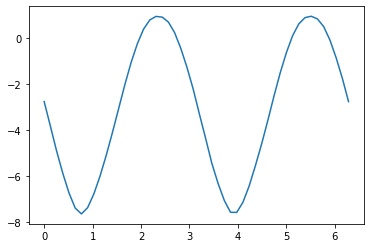

In [29]:
plt.plot(thetas, np.log(Rs))

### Try gradient descent

In [150]:
tension = Tension(2)
tension.state_dict()["linear.weight"].copy_(torch.tensor([[-0.3, 0.6]]))
tension.state_dict()["linear.bias"].copy_(torch.tensor([0]))
criterion = BayesFactor(1000)
optimizer = optim.SGD(tension.parameters(), lr=0.001)

losses = []
weights = torch.tensor([])
biases = torch.tensor([])
for i in range(100):
    optimizer.zero_grad()
    X0_1d = tension(X0_tensor)
    X1_1d = tension(X1_tensor)
    X_prior_1d = tension(X_prior_tensor)
    loss = torch.log(criterion(X0_1d, X1_1d, X_prior_1d))
    losses.append(loss.item())
    weights = torch.cat((weights, tension.linear.weight))
    biases = torch.cat((biases, tension.linear.bias))
    loss.backward()
    optimizer.step()

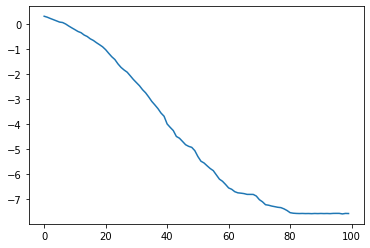

In [151]:
plt.plot(np.arange(100), losses)

In [152]:
tension.linear.weight

Parameter containing:
tensor([[0.8078, 0.8839]], requires_grad=True)

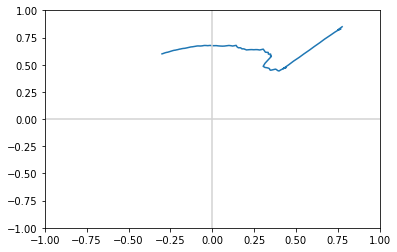

In [159]:
plt.plot(weights.detach().numpy()[:, 0], weights.detach().numpy()[:, 1])
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.axvline(0, color='lightgrey')
plt.axhline(0, color='lightgrey')